# ***Examen práctico parical 1***
### Luis Eduardo Jiménez del Muro - 21/02/2025
---

## Paqueterías y funciones 

In [1]:
# Paqueterías
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Funciones

# Gráfica de calibracion
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    r2 = r2_score(y_pred=predicciones, y_true=y)
    
    # Gráfica
    plt.figure(figsize=(6,4))
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', marker='o', color='cadetblue', ms=4, lw=1)
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='red', ms=4, lw=1)
    plt.title(f'Calibración del modelo \n\n$R2={r2:.4f}$')
    plt.grid(alpha=0.5)
    plt.legend()
    plt.xlabel('Predicción')
    plt.ylabel('Real')

# **Información del Dataset**

+ CRIM - per capita crime rate by town

+ ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

+ INDUS - proportion of non-retail business acres per town.

+ CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

+ NOX - nitric oxides concentration (parts per 10 million)

+ RM - average number of rooms per dwelling

+ AGE - proportion of owner-occupied units built prior to 1940

+ DIS - weighted distances to five Boston employment centres

+ RAD - index of accessibility to radial highways

+ TAX - full-value property-tax rate per $10,000

+ PTRATIO - pupil-teacher ratio by town

+ B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

+ LSTAT - % lower status of the population

+ MEDV - Median value of owner-occupied homes in $1000's

# **Análisis Exploratorio**

## *Limpieza de datos*

In [3]:
df = pd.read_csv('Boston.csv')
df.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [4]:
df = df.drop(columns=['Unnamed: 0'])

In [5]:
df.isna().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
lstat      0
medv       0
dtype: int64

In [6]:
df.nunique()

crim       504
zn          26
indus       76
chas         2
nox         81
rm         446
age        356
dis        412
rad          9
tax         66
ptratio     46
lstat      455
medv       229
dtype: int64

In [7]:
df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


### Crear variables dummy

+ A pesar de que los datos que hay en `rad` son numéricos, en realiadad representan categorías sobre la accesibilidad a las carreteras radiales.

+ En cuanto a `chas` no será necesario obtener dummies dado que ya es está en el formato de dummy.

In [8]:
categorical = ['chas', 'rad'] # No se elige chas porque ya está en formato de dummy
numerical = df.drop(columns=categorical).columns.tolist()

df = pd.get_dummies(df, columns=['rad'])
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,tax,ptratio,...,medv,rad_1,rad_2,rad_3,rad_4,rad_5,rad_6,rad_7,rad_8,rad_24
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,296,15.3,...,24.0,True,False,False,False,False,False,False,False,False
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,242,17.8,...,21.6,False,True,False,False,False,False,False,False,False
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,242,17.8,...,34.7,False,True,False,False,False,False,False,False,False
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,222,18.7,...,33.4,False,False,True,False,False,False,False,False,False
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,222,18.7,...,36.2,False,False,True,False,False,False,False,False,False


## *Visualización de los datos*

### Scatterplots contra el target

In [9]:
target = 'medv'

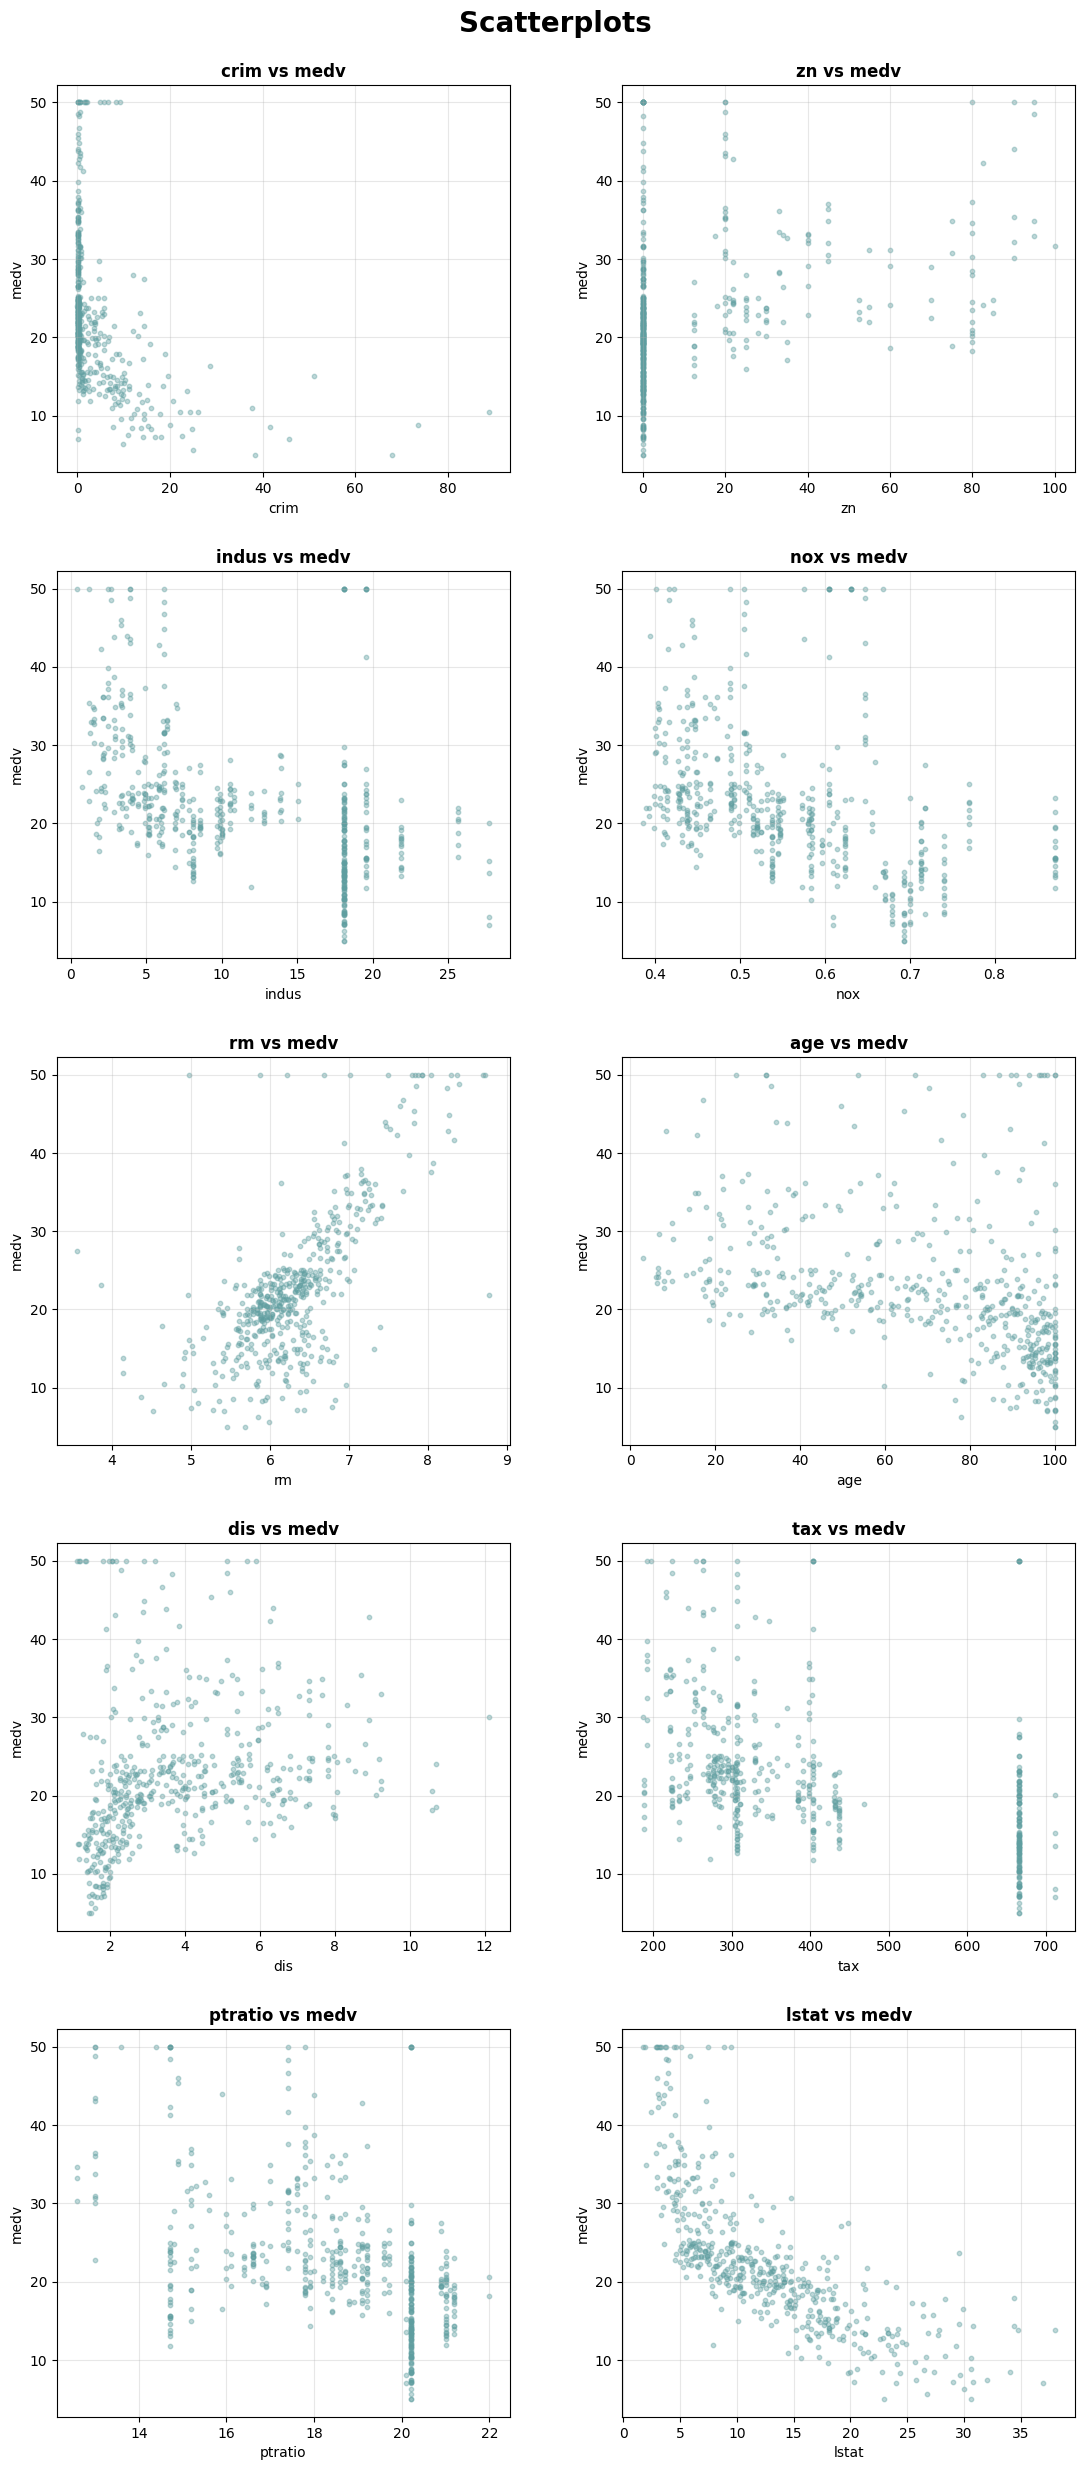

In [10]:
num_vars = len(numerical) 

fig, axes = plt.subplots(5, 2, figsize=(12, 25))
fig.tight_layout(pad=5)
fig.suptitle('Scatterplots', fontsize=20, fontweight='bold', y=1)

for i, ax in enumerate(axes.flat):
    if i < num_vars:
        ax.scatter(df[numerical[i]], df[target], marker='o', color='cadetblue', s=10, alpha=0.4)
        ax.set_title(f'{numerical[i]} vs {target}', fontsize=12, fontweight='bold')
        ax.set_xlabel(numerical[i])
        ax.set_ylabel(target)
        ax.grid(alpha=0.3)
    else:
        ax.remove() # Eliminar subplots vacíos

plt.show()

#### Observaciones

+ Variables como `lstat` y `rm` son las únicas a las que a simple vista podría parecer que se les puede ajustar una recta o polinomio.

+ `crim` y `zn` tienen una alta concentración de datos en cero.

+ Hay un salto muy grande en `tax` entre $450$ y $650$.

+ Las demás variables presentan mucha dispersión, por lo que, será mejor realizar un análisis bivariado para poder comprender mejor las relaciones con la variable objetivo.

### Análisis bivariado

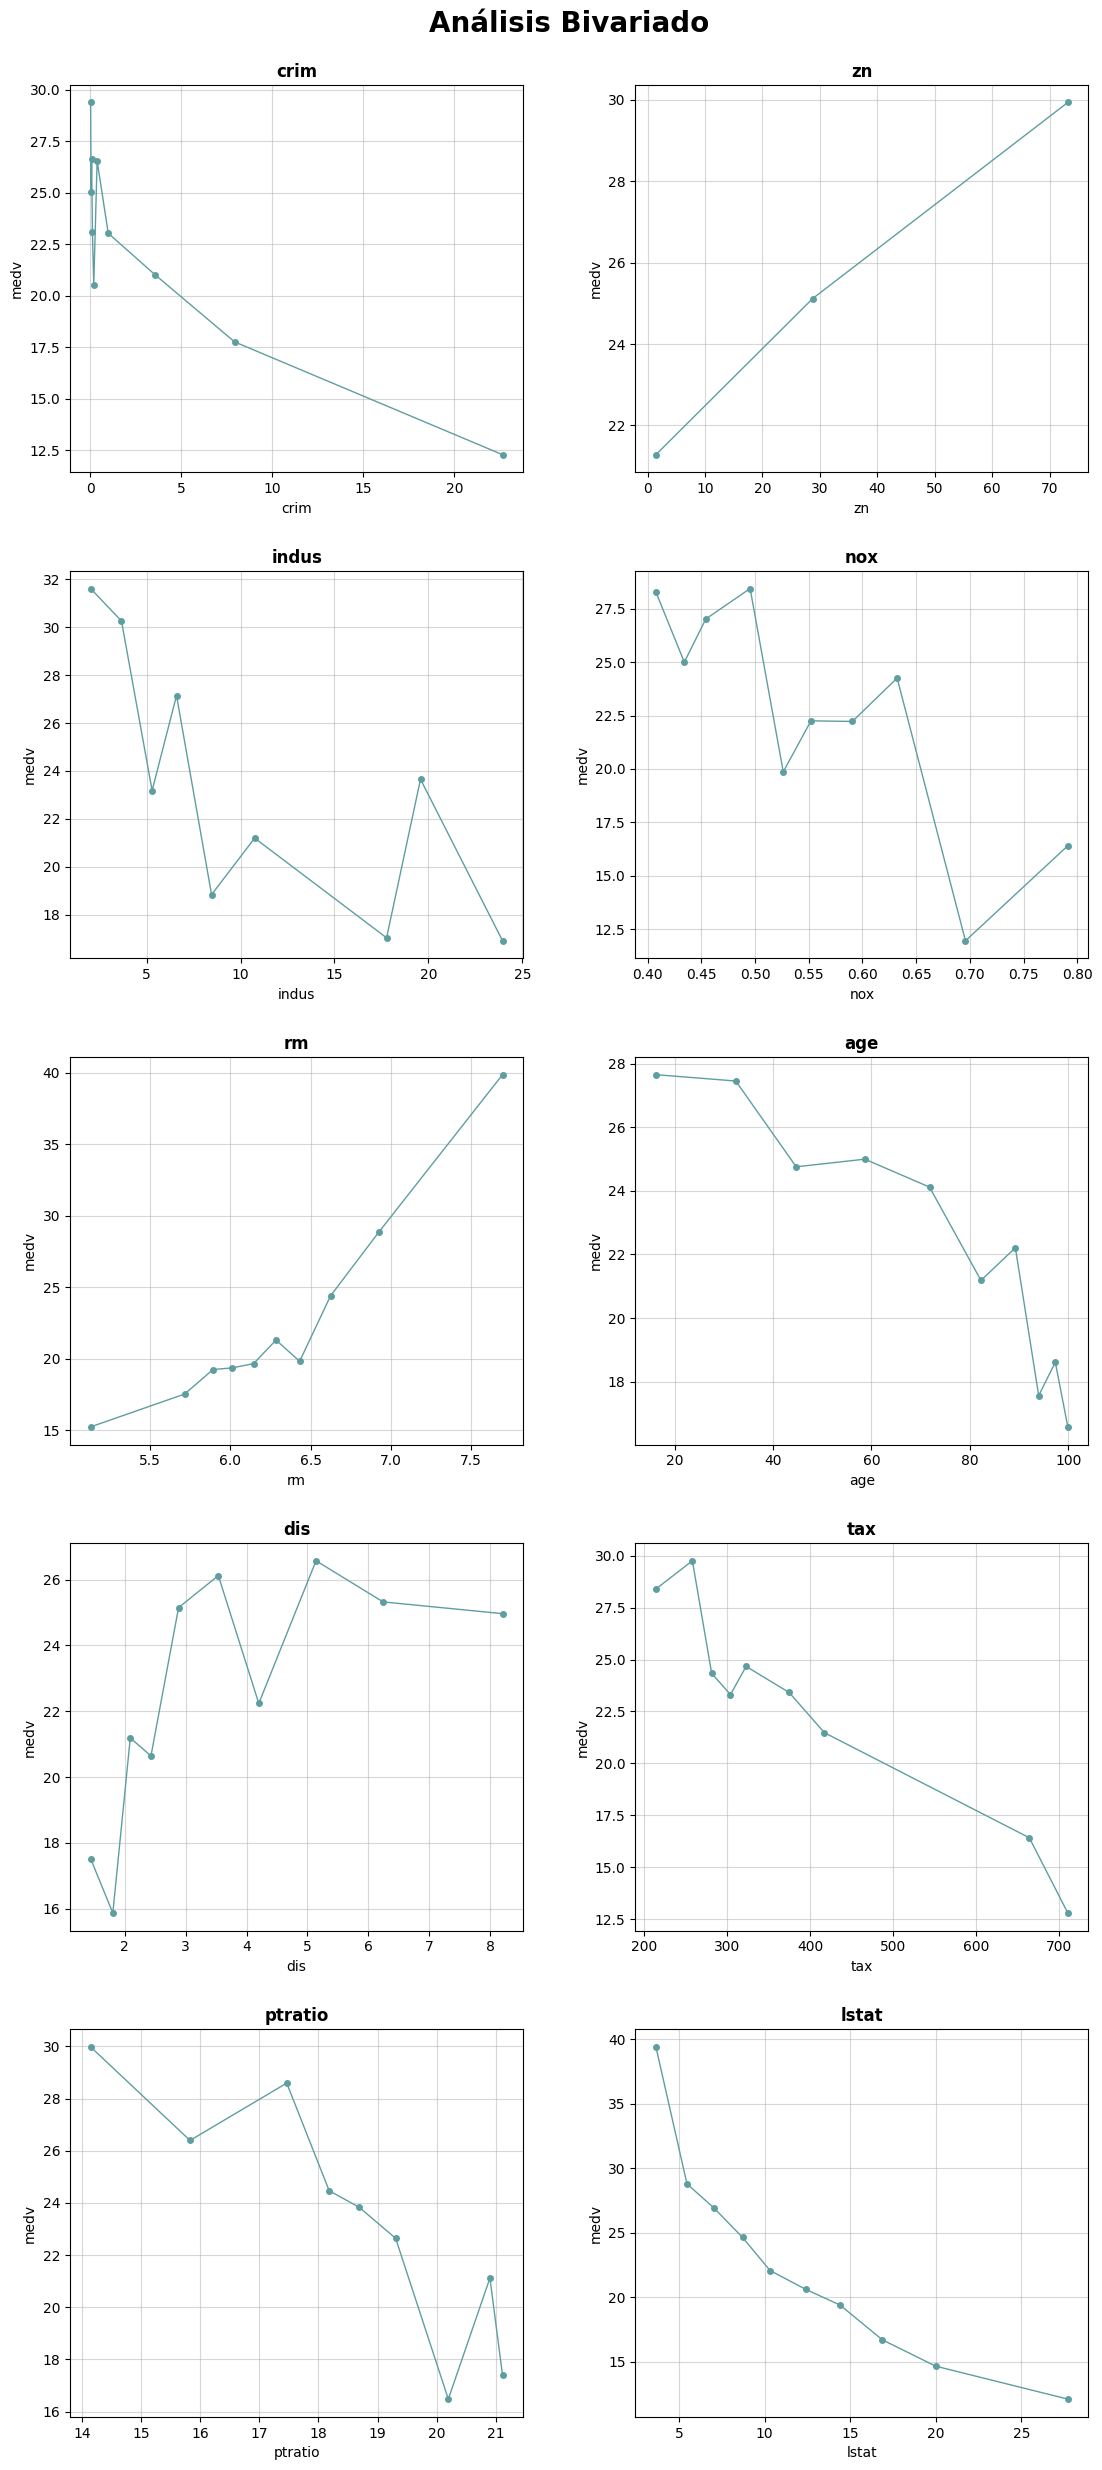

In [11]:
df_bivariado = df.copy()

fig, axes = plt.subplots(5, 2, figsize=(12, 25))
fig.tight_layout(pad=5)
fig.suptitle('Análisis Bivariado', fontsize=20, fontweight='bold', y=1)

for i, ax in enumerate(axes.flat):
    if i < num_vars:
        df_bivariado[f'{numerical[i]}_bins'] = pd.qcut(df_bivariado[numerical[i]], q=10, labels=False, duplicates='drop') + 1
        grouped_data = df_bivariado.groupby(f'{numerical[i]}_bins').mean()
            
        ax.plot(grouped_data[numerical[i]], grouped_data[target], marker='o', color='cadetblue', lw=1, markersize=4)
        ax.set_title(numerical[i], fontsize=12, fontweight='bold')
        ax.set_xlabel(numerical[i])
        ax.set_ylabel(target)
        ax.grid(alpha=0.5)
    else:
        ax.remove() # Eliminar subplots vacíos

plt.show()

#### Observaciones 

+ Solo hay una variable que se relaciona linealmente con el target de forma muy clara y es `zn`.

+ Variables como `rm` y `tax` tambien, podrían relacionarse linealmente. Sin embargo, podrian intentarse ajustar potencias diferentes.

+ `nox` y `ptratio` son variables con mucha dispersión, por ende, tambien habrá que probar si se ajustan mejor polinomios o rectas.

+ A pesar de que `indus` y `dis` tienen mucha dispersión, pueden relacionarse de forma cuadrática o algun otro grado de polinomio.

+ Con `crim`, `age` y `lstat` se observan relaciones cuadráticas claras.

### Histogramas

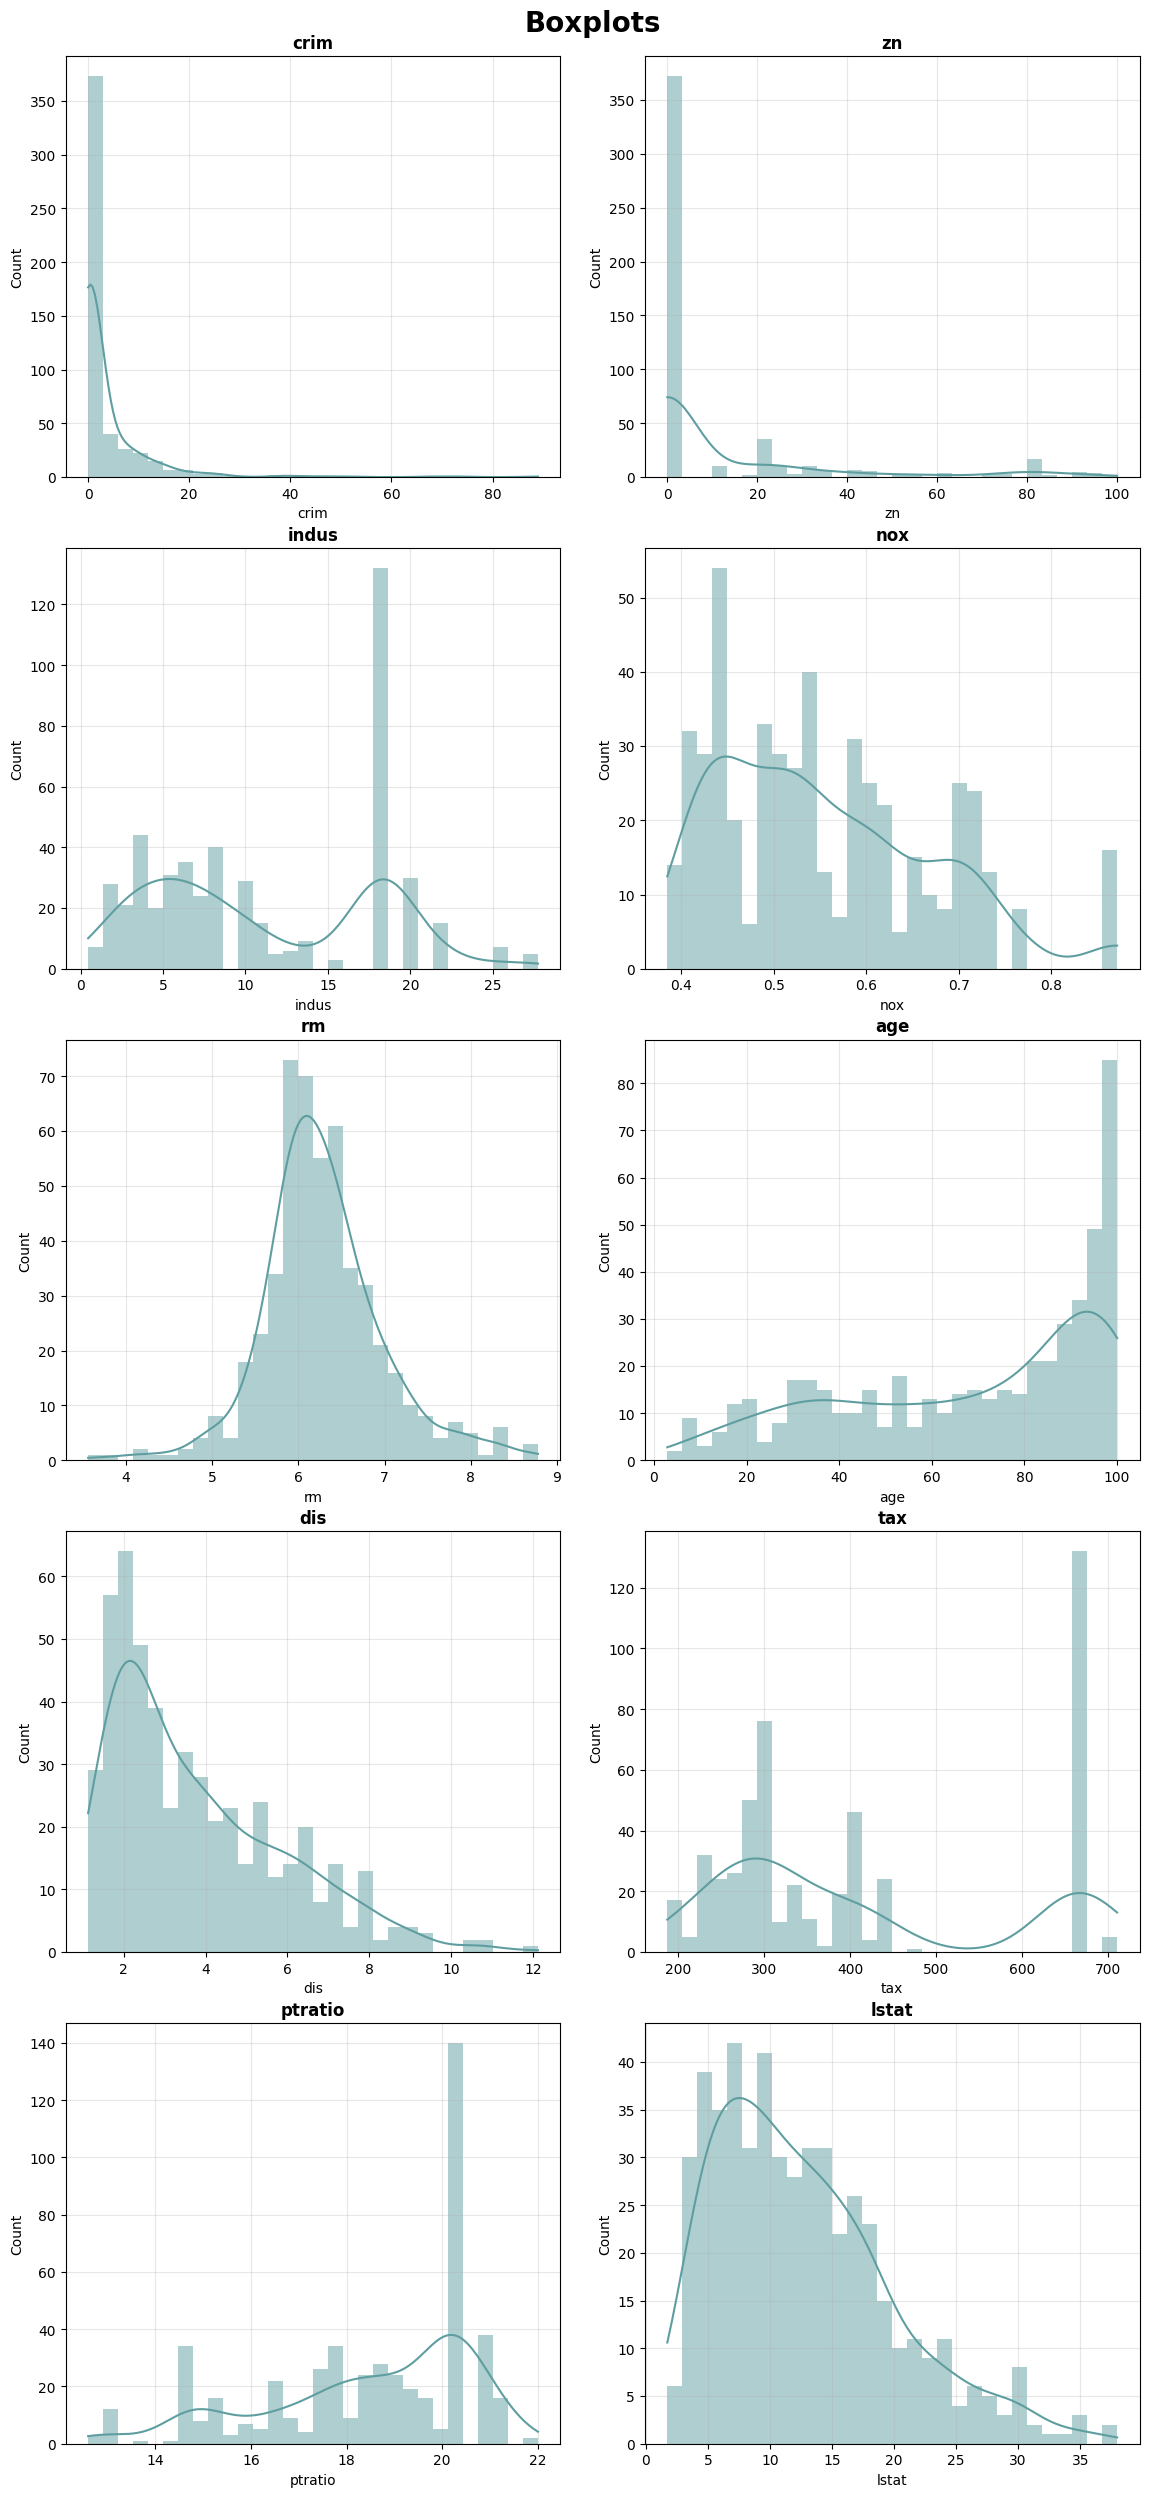

In [12]:
fig, axes = plt.subplots(5, 2, figsize=(12,25))
fig.tight_layout(pad=3)
fig.suptitle('Boxplots', fontsize=20, fontweight='bold', y=1)


for i, ax in enumerate(axes.flat):
    if i < num_vars:
        sns.histplot(df[numerical[i]],  color="cadetblue", kde=True, ax=ax, bins=30,  edgecolor=None)
        ax.set_title(numerical[i], fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3)
    else:
        ax.remove() # Eliminar subplots vacíos


plt.show()

#### Observaciones

+ Podemos confirmar la alta cantidad de datos que existen en cero en las variables de `crim` y `zn`.

+ Los datos se distribuyen de formas muy diferentes entre sí, por lo que, sería conveniente probar haciendo estandarizaciones.

### Boxplots

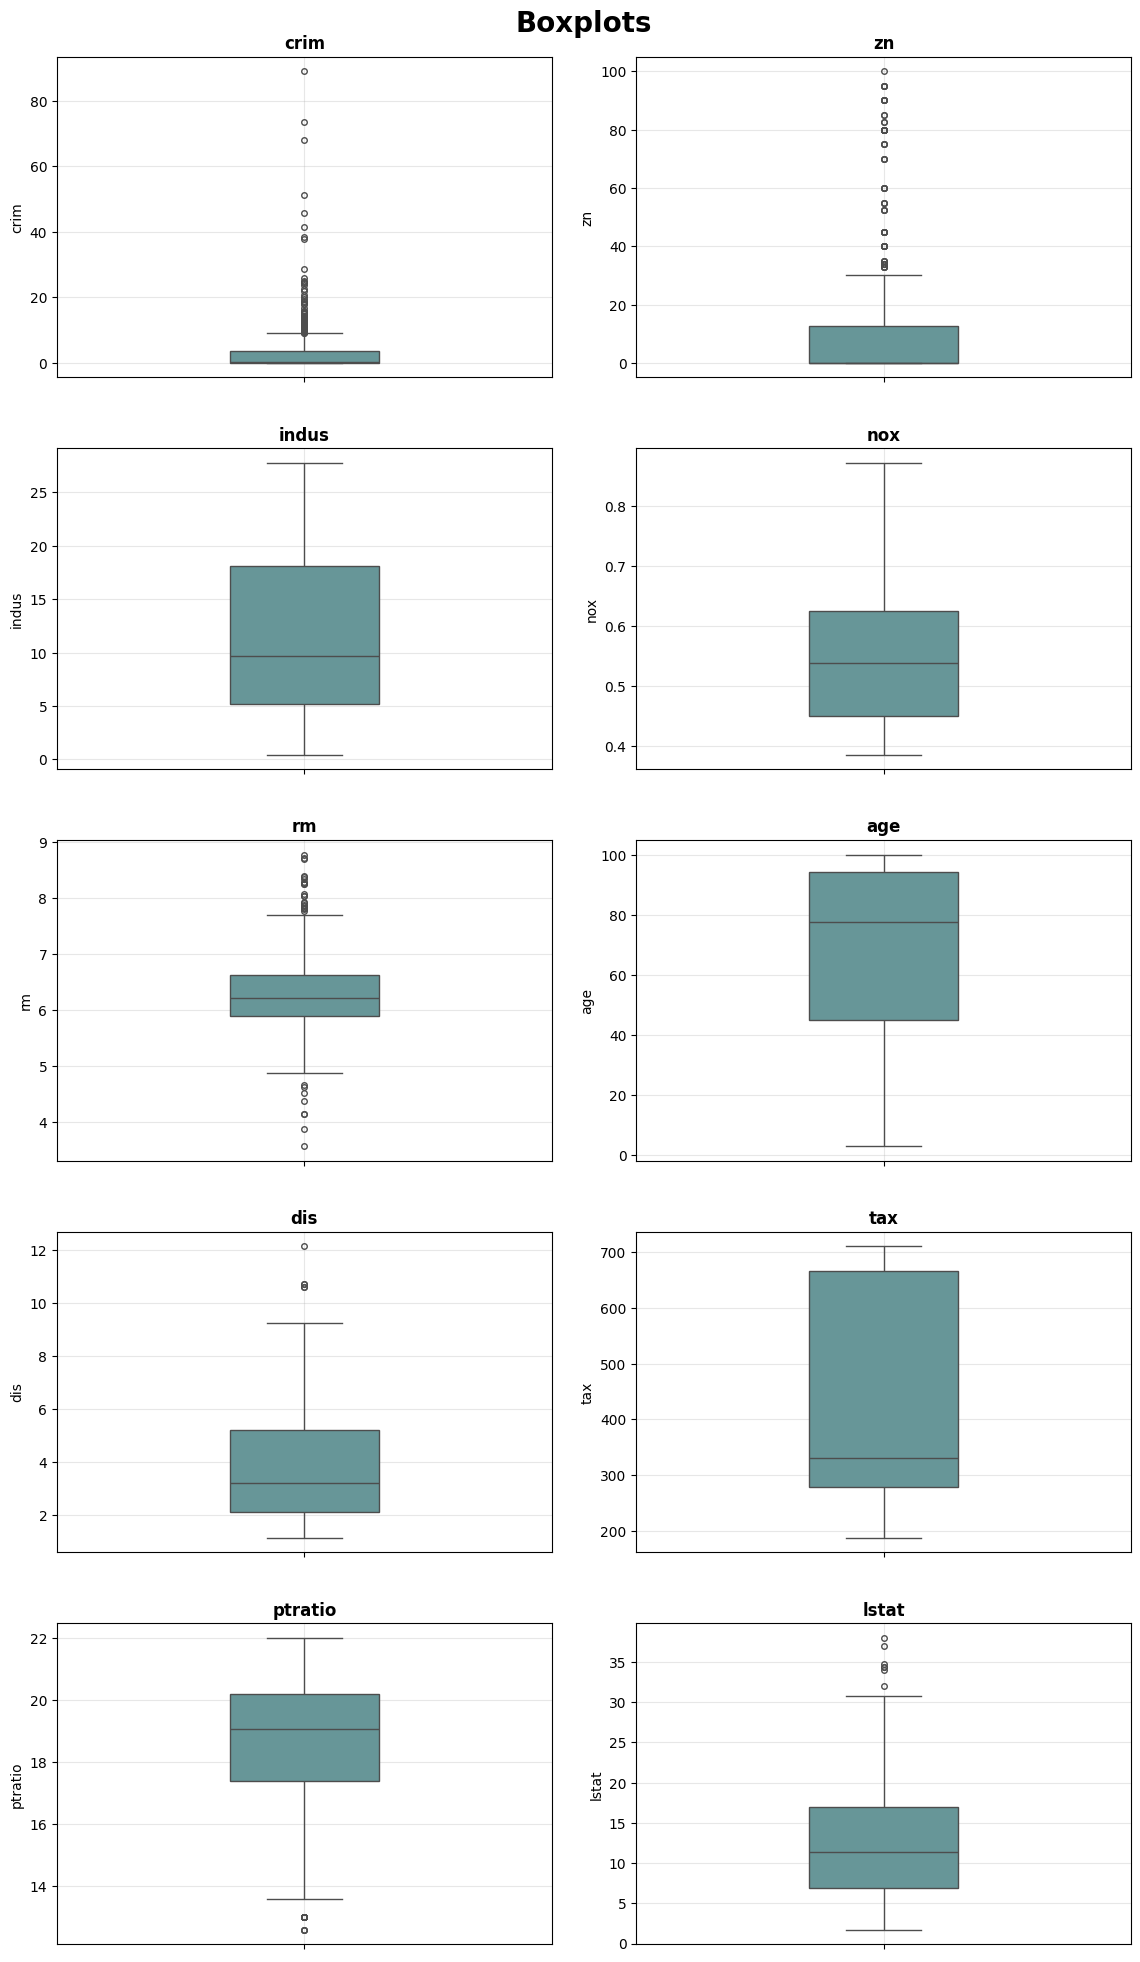

In [13]:
fig, axes = plt.subplots(5, 2, figsize=(12,20))
fig.tight_layout(pad=3)
fig.suptitle('Boxplots', fontsize=20, fontweight='bold', y=1)

for i, ax in enumerate(axes.flat):
    if i < num_vars:
        sns.boxplot(y=df[numerical[i]], ax=ax, color="cadetblue", width=0.3, flierprops={'marker': 'o', 'markersize': 4})
        ax.set_title(numerical[i], fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3)
    else:
        ax.remove() # Eliminar subplots vacíos

plt.show()

#### Observaciones

+ Dada la alta concentración de datos en cero de `crim` y `zn`, observamos que tambien hay muchos outliers, que podrían llegar a darle información importante al modelo, o incluso perjudicarlo.

+ `rm`, `dis`, `lstat` y `ptratio` tambien presentan outliers.

+ Al momento de hacer modelos, harán prubeas controlando y no controlando los outliers para ver como modifican el desempeño del modelo. Por ejemplo, al momento de hacer estandarización, controlar los datos que sean menores a $-3$ y mayores a $3$.

## *Feature Engeneering*

En esta sección se crearán nuevas variables y modificarán algunas de las actuales. Además se crearan __ nuevos dataframes que contengan diferentes combinaciones de las nuevas variables con las originales, para probar el desempeño de los modelos utilizando y sin utilizar estas variables

### Modificación de variables actuales variables

Como observamos en las gráficas del análisis exploratorio, podemos modificar algunas de nuestras variables para tratar de controlar los datos atípicos, y tambien corregir las relaciones polinómicas que tienen algunas variables con el target. Entonces se proponen las siguientes modificaciones de variables:

* `rm`: potencia 2.
* `tax`: potencia 2.
* `nox`: potencia 2.
* `ptratio`: potencia 2.
* `indus`: potencia 2.
* `crim`: potencia 2.
* `age`: potencia 2.
* `lstat`: potencia 2.
* `rm`: logaritmo natural.

### Creación de nuevas variables

A partir de los datos que se tienen, es posible proponer nuevas variables:

* `crim / indus`: Relación entre criminalidad y zonas industriales.
* `crim / lstat`: Relación entre criminalidad y % de estatus inferior de la población.
* `rm / lstat`: Relación entre promedio de habitaciones y % de estatus inferior de la población.
* `nox / indus`: Relación entre la concentración de óxidos nítricos de habitaciones y zonas industriales.
* `nox / dis`: Relación entre la concentración de óxidos nítricos de habitaciones y las distancias a los centros de empleo.
* `age / lstat`: Relación entre la las casas ocupadas que se construyeron antes de 1940 y el % de status inferior de la población.
* `tax / rm`: Relación entre los impuestos y la cantidad de habitaciones.
* `tax / lstat`: Los impuestos y el % de status inferior de la población.
* `ptratio / rm`: Relación entre la educación y las gabitaciones promedio.
* `ptratio / nox`: Relación entre la educación y la concentración de óxidos nítricos.
* `ptratio / dis`: Relación entre la educación y la distancia a los centros de empleo.

### Creación de los nuevos DataFrames

In [14]:
# Variables modificadas
modified_features_df = pd.DataFrame()
modified_features_df['rm**2'] = df['rm']**2
modified_features_df['tax**2'] = df['tax']**2
modified_features_df['nox**2'] = df['nox']**2
modified_features_df['ptratio**2'] = df['ptratio']**2
modified_features_df['indus**2'] = df['indus']**2
modified_features_df['crim**2'] = df['crim']**2
modified_features_df['age**2'] = df['age']**2
modified_features_df['lstat**2'] = df['lstat']**2
modified_features_df['ln(dis)'] = np.log(1+df['dis']) # +1 para evitar ln(0)

# Nuevas variables
new_features_df = pd.DataFrame()
new_features_df['crim_indus'] = df['crim'] / (1+df['indus']) # +1 para evitar divisiones entre cero
new_features_df['crim_lstat'] = df['crim'] / (1+df['lstat'])
new_features_df['rm_lstat'] = df['rm'] / (1+df['lstat'])
new_features_df['nox_indus'] = df['nox'] / (1+df['indus'])
new_features_df['nox_dis'] = df['nox'] / (1+df['dis'])
new_features_df['age_lstat'] = df['age'] / (1+df['lstat'])
new_features_df['tax_rm'] = df['tax'] / (1+df['rm'])
new_features_df['tax_lstat'] = df['tax'] / (1+df['lstat'])
new_features_df['ptratio_rm'] = df['ptratio'] / (1+df['rm'])
new_features_df['ptratio_nox'] = df['ptratio'] / (1+df['nox'])
new_features_df['ptratio_dis'] = df['ptratio'] / (1+df['dis'])

# Nuevos dataframes para futuras pruebas
df_mod_plus_originals = pd.concat([df, modified_features_df], axis=1)
df_new_feat_plus_originals = pd.concat([df, new_features_df], axis=1)
df_all_new_plus_originals = pd.concat([df, modified_features_df, new_features_df], axis=1)
df_all_new_not_originals = pd.concat([(df.drop(columns=['rm', 'tax', 'nox', 'ptratio', 'indus', 'crim', 'age', 'lstat', 'dis'])), 
                                      modified_features_df, new_features_df], axis=1)

## *Feature Selection*

Ahora, analizaremos principalmente lo significativas que son nuestras variables para el modelo, y tomar decisiones de descartarlas o dejarlas. Para ello, se usarán las pruebas de hipótesis de `statsmodel`.

## *Prueba de modelos*

### Regresión lineal múltiple con los datos originales + dummies.

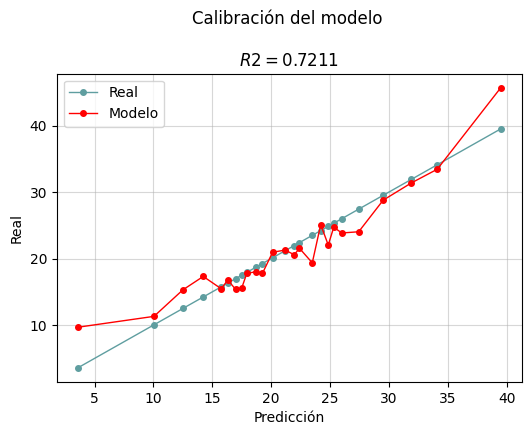

In [15]:
X = df.copy().drop(columns=target)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LinearRegression().fit(X_train, y_train)
predicciones_lineal = model.predict(X_test)
calibracion(predicciones_lineal, y_test, 25)

#### Observaciones

### Regresión polinómica grado 2 con los datos originales + dummies.

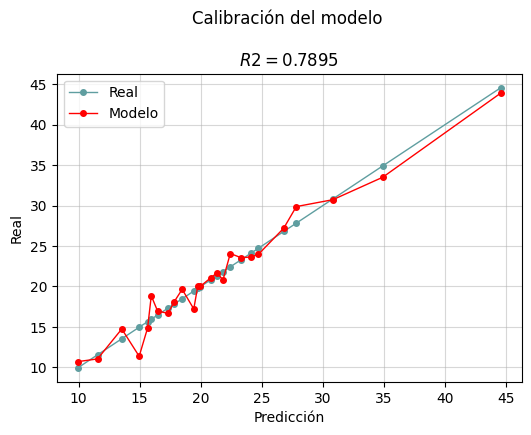

In [16]:
X = df.copy().drop(columns=target)
y = df[target]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

degree = 2

poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = Ridge().fit(X_train, y_train)
predicciones_poly_2 = model.predict(X_test)

calibracion(predicciones_poly_2, y_test, 25)

#### Observaciones

### Regresión polinómica grado 3 con los datos originales + dummies.

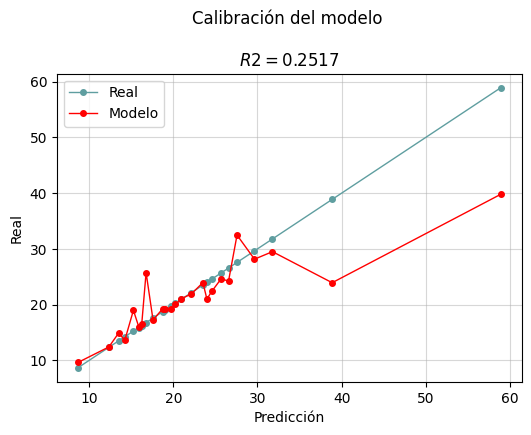

In [22]:
X = df.copy().drop(columns=target)
y = df[target]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

degree = 3

poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = Ridge().fit(X_train, y_train)
predicciones_poly_2 = model.predict(X_test)

calibracion(predicciones_poly_2, y_test, 25)